In [1]:
import numpy as np
import pandas as pd
import networkx as nx 
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import pickle
import json
from pathlib import Path
import time
from tqdm import tqdm
from joblib import Parallel, delayed, dump, load
import random
import _utilities

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

In [2]:
with open( './cells_of_interest.json', 'r') as f:
   cells_of_interest = json.load(f)

In [3]:
len(cells_of_interest)

334

In [4]:
with open('./cells_info.pickle', 'rb') as f:
    cells_info = pickle.load(f)
# cells_info['ABal']
with open('./embryo_cells_info.pickle', 'rb') as f:
    embryo_cells_info = pickle.load(f)
# embryo_cells_info['WT-EMB12']['ABal']

In [5]:
embryos_for_test = ['WT-EMB05','WT-EMB12','WT-EMB19','WT-EMB26']
embryos_for_cross_validation = [embryo_name for embryo_name in embryo_cells_info if embryo_name not in embryos_for_test]

In [6]:
print(embryos_for_cross_validation)

['WT-EMB01', 'WT-EMB02', 'WT-EMB03', 'WT-EMB04', 'WT-EMB06', 'WT-EMB07', 'WT-EMB08', 'WT-EMB09', 'WT-EMB10', 'WT-EMB11', 'WT-EMB13', 'WT-EMB14', 'WT-EMB15', 'WT-EMB16', 'WT-EMB17', 'WT-EMB18', 'WT-EMB20', 'WT-EMB21', 'WT-EMB22', 'WT-EMB23', 'WT-EMB24', 'WT-EMB25', 'WT-EMB27', 'WT-EMB28']


In [7]:
len(embryos_for_cross_validation)

24

# LSTM with time model --- LSTMt

Here we use one-layer LSTM, and this time LSTM accepts (t,x,y,z) format trajectory data instead of (x,y,z) format trajectory data in './rnn lstm.ipynb'.

In [8]:
class LSTMt(nn.Module):
    def __init__(self, output_size = 334, num_rnn_layer = 1):
        super().__init__()
        self.flat = nn.Flatten() # flatten features
        self.unflat = nn.Unflatten(1, (50,4))  # trajectory input of shape (N, Lx4) to (N, L, 4), where N is batch_size, L=50 is seq_length
        # Hidden layer
        self.rnn = nn.LSTM(4, 4, num_layers=num_rnn_layer, batch_first=True) # (x,y,z)
        # final Output layer
        self.fc_out = nn.LazyLinear(output_size) # output layer

    def forward(self, x, x_extra = None):
        """_summary_

        Parameters
        ----------
        x : tensor
            trajectory features
        x_extra : tensor
            extra features, like start_frame, lifespan, division orientations, by default None

        Returns
        -------
        tensor
            forward pass of (x, x_extra)
        """     
        # trajectory branch
        # convert x from (N, Lx4) to (N, L, 4), where L should be 50
        out = self.unflat(x)
        out, _ = self.rnn(out) # out is of shape (N, L, H_out), where N is batch_size, L is seq_length, H_out is hidden feature size. In our case, out is of shape (N, 50, 4)  
        out = self.flat(out) # to shape (N, 50*4)
        # no extra features as input, only trajectory
        if x_extra is None: 
            out = self.fc_out(out)
        else:
            x_extra = self.flat(x_extra)
            out = torch.cat((out, x_extra), dim = 1)
            out = self.fc_out(out)
        return out

## StandScaler applied to all features including time features

In [9]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device=='cuda':
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False

# Batch_size
batch_size = 128

# Prepare data

# train and val data
i = 0
embryos_val = embryos_for_cross_validation[4*i:4*i+4]
embryos_train = [embryo_name for embryo_name in embryos_for_cross_validation if embryo_name not in embryos_val]
X_train, _, y_train = _utilities.prepare_data_for_model(embryo_cells_info, embryos_train, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)
X_val, _, y_val = _utilities.prepare_data_for_model(embryo_cells_info, embryos_val, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)
# test data
X_test, _, y_test = _utilities.prepare_data_for_model(embryo_cells_info, embryos_for_test, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)

# feature normalization
scaler = StandardScaler()
scaler.fit(np.array(X_train))
X_train = scaler.transform(np.array(X_train))
# standardize X_val and X_test
X_val = scaler.transform(np.array(X_val))
X_test = scaler.transform(np.array(X_test))


# Dataset
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_train, dtype=np.float32)), torch.from_numpy(np.array(y_train)).type(torch.LongTensor))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_val, dtype=np.float32)), torch.from_numpy(np.array(y_val)).type(torch.LongTensor))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_test, dtype =np.float32)), torch.from_numpy(np.array(y_test)).type(torch.LongTensor))
# Dataloader 
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Train and Validate model
model = LSTMt(output_size=len(cells_of_interest)).to(device)
lr = 0.001
weight_decay=0.1 # L2 regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

num_epochs = 3000
test_interval = 10
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
test_accuracy = []

start_time = time.time()
# Training
for epoch in range(num_epochs):
    acc_train, loss_train = _utilities.train_mlp(model, train_dl, optimizer, device)
    acc_valid, loss_valid = _utilities.evaluate_mlp(model, val_dl, optimizer, device)
    scheduler.step() # adjust lr
    train_loss.append(loss_train)
    train_accuracy.append(acc_train)
    val_loss.append(loss_valid)
    val_accuracy.append(acc_valid)
    print(f'Epoch: {epoch+1:04d}/{num_epochs:04d} | '
          f'Accuracy: {acc_train:.4f} | '
          f'Val_accuracy: {acc_valid:.4f} | '
          f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
    if (epoch+1)%test_interval == 0: # test every 50 epochs
        # Test
        acc_test, _ = _utilities.evaluate_mlp(model, test_dl, optimizer, device)
        test_accuracy.append(acc_test)
        print(f'Test_accuracy: {acc_test:.4f}') 
# Test
acc_test, _ = _utilities.evaluate_mlp(model, test_dl, optimizer, device)
# test_accuracy.append(acc_test)
print(f'Final Test_accuracy: {acc_test:.4f}')

c:\Users\pmcesky\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 0001/3000 | Accuracy: 0.0323 | Val_accuracy: 0.0921 | Time elapsed: 0.03 min
Epoch: 0002/3000 | Accuracy: 0.1196 | Val_accuracy: 0.2328 | Time elapsed: 0.04 min
Epoch: 0003/3000 | Accuracy: 0.2181 | Val_accuracy: 0.3121 | Time elapsed: 0.05 min
Epoch: 0004/3000 | Accuracy: 0.2747 | Val_accuracy: 0.3750 | Time elapsed: 0.06 min
Epoch: 0005/3000 | Accuracy: 0.3551 | Val_accuracy: 0.4641 | Time elapsed: 0.08 min
Epoch: 0006/3000 | Accuracy: 0.4153 | Val_accuracy: 0.5165 | Time elapsed: 0.09 min
Epoch: 0007/3000 | Accuracy: 0.4741 | Val_accuracy: 0.5404 | Time elapsed: 0.10 min
Epoch: 0008/3000 | Accuracy: 0.5099 | Val_accuracy: 0.5689 | Time elapsed: 0.11 min
Epoch: 0009/3000 | Accuracy: 0.5473 | Val_accuracy: 0.5936 | Time elapsed: 0.13 min
Epoch: 0010/3000 | Accuracy: 0.5657 | Val_accuracy: 0.5876 | Time elapsed: 0.14 min
Test_accuracy: 0.5868
Epoch: 0011/3000 | Accuracy: 0.5760 | Val_accuracy: 0.6040 | Time elapsed: 0.15 min
Epoch: 0012/3000 | Accuracy: 0.5955 | Val_accuracy: 0.

In [11]:
print(test_accuracy)

[0.5868263473053892, 0.688622754491018, 0.7462574850299402, 0.7851796407185628, 0.8023952095808383, 0.8203592814371258, 0.8278443113772455, 0.8263473053892215, 0.8360778443113772, 0.8398203592814372, 0.844311377245509, 0.8480538922155688, 0.8398203592814372, 0.8413173652694611, 0.8473053892215568, 0.8488023952095808, 0.8465568862275449, 0.8458083832335329, 0.8525449101796407, 0.8525449101796407, 0.8517964071856288, 0.8577844311377245, 0.8562874251497006, 0.8585329341317365, 0.8570359281437125, 0.8615269461077845, 0.8652694610778443, 0.8637724550898204, 0.8577844311377245, 0.8592814371257484, 0.8615269461077845, 0.8637724550898204, 0.8690119760479041, 0.8570359281437125, 0.8682634730538922, 0.8652694610778443, 0.8682634730538922, 0.8660179640718563, 0.8682634730538922, 0.8660179640718563, 0.8697604790419161, 0.8682634730538922, 0.8645209580838323, 0.874251497005988, 0.8690119760479041, 0.8705089820359282, 0.8690119760479041, 0.875, 0.875, 0.8712574850299402, 0.874251497005988, 0.8727544

Text(0.5, 1.025, '1 layer LSTM training')

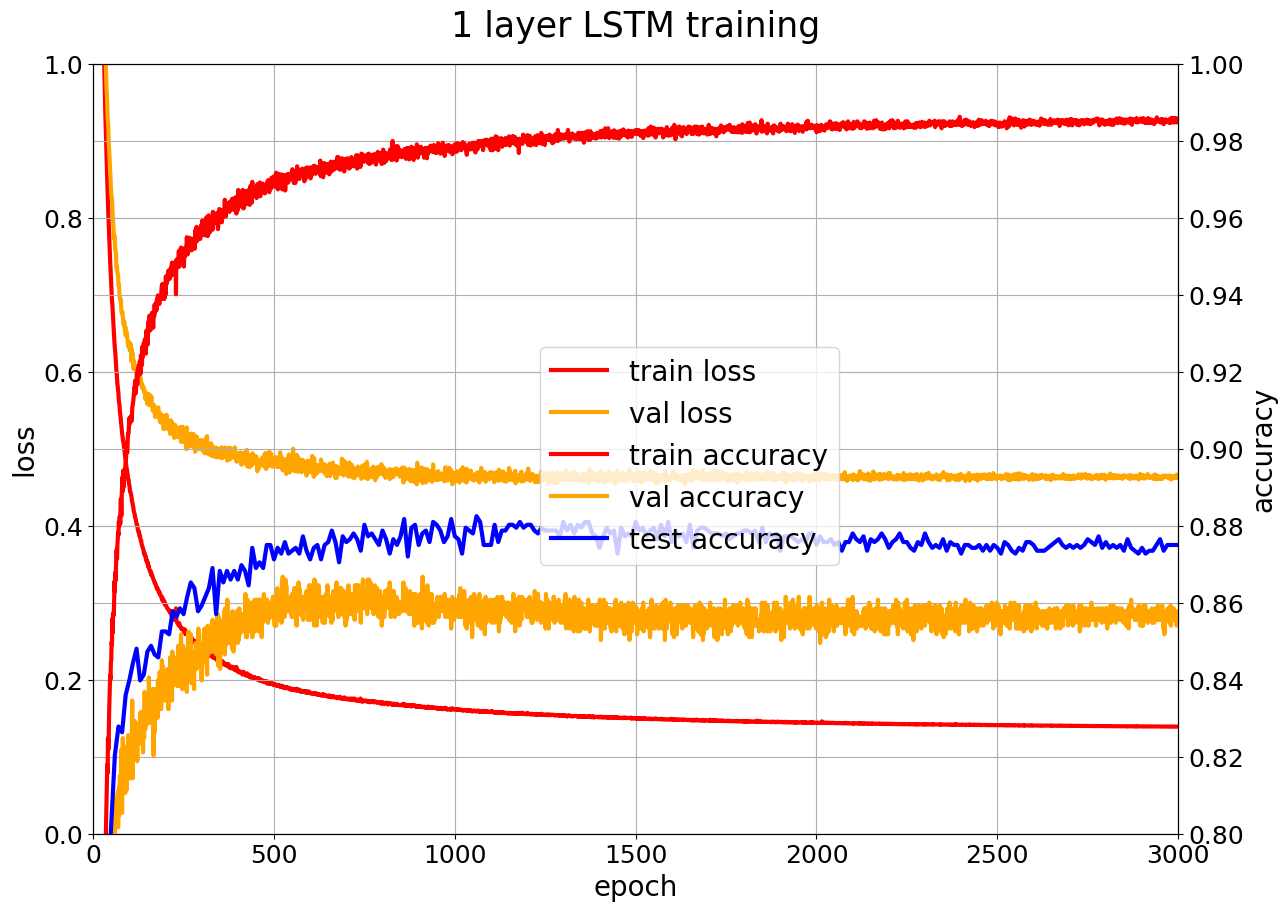

In [10]:
# AdamW, l2 weight_decay = 0.1, lr = 0.001, lr schedule exp decay gamma = 0.999, batch_size = 128, with feature standardization, 1 Layer LSTM
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


## No StandardScaler on features

In above the time dimension is added, but the time dimension is standardized in StandardScaler(), this may be not good for LSTM.
how about we do not apply StandardScaler() on features at all, and see how it goes. Here all features are original features, no StandardScaler applied here.

In [17]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device=='cuda':
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False

# Batch_size
batch_size = 128

# Prepare data

# train and val data
i = 0
embryos_val = embryos_for_cross_validation[4*i:4*i+4]
embryos_train = [embryo_name for embryo_name in embryos_for_cross_validation if embryo_name not in embryos_val]
X_train, _, y_train = _utilities.prepare_data_for_model(embryo_cells_info, embryos_train, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)
X_val, _, y_val = _utilities.prepare_data_for_model(embryo_cells_info, embryos_val, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)
# test data
X_test, _, y_test = _utilities.prepare_data_for_model(embryo_cells_info, embryos_for_test, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)

# feature normalization
# scaler = StandardScaler()
# scaler.fit(np.array(X_train))
# X_train = scaler.transform(np.array(X_train))
# # standardize X_val and X_test
# X_val = scaler.transform(np.array(X_val))
# X_test = scaler.transform(np.array(X_test))


# Dataset
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_train, dtype=np.float32)), torch.from_numpy(np.array(y_train)).type(torch.LongTensor))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_val, dtype=np.float32)), torch.from_numpy(np.array(y_val)).type(torch.LongTensor))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_test, dtype =np.float32)), torch.from_numpy(np.array(y_test)).type(torch.LongTensor))
# Dataloader 
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Train and Validate model
model = LSTMt(output_size=len(cells_of_interest)).to(device)
lr = 0.001
weight_decay=0.05 # L2 regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

num_epochs = 3000
test_interval = 10
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
test_accuracy = []

start_time = time.time()
# Training
for epoch in range(num_epochs):
    acc_train, loss_train = _utilities.train_mlp(model, train_dl, optimizer, device)
    acc_valid, loss_valid = _utilities.evaluate_mlp(model, val_dl, optimizer, device)
    scheduler.step() # adjust lr
    train_loss.append(loss_train)
    train_accuracy.append(acc_train)
    val_loss.append(loss_valid)
    val_accuracy.append(acc_valid)
    print(f'Epoch: {epoch+1:04d}/{num_epochs:04d} | '
          f'Accuracy: {acc_train:.4f} | '
          f'Val_accuracy: {acc_valid:.4f} | '
          f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
    if (epoch+1)%test_interval == 0: # test every 50 epochs
        # Test
        acc_test, _ = _utilities.evaluate_mlp(model, test_dl, optimizer, device)
        test_accuracy.append(acc_test)
        print(f'Test_accuracy: {acc_test:.4f}') 
# Test
acc_test, _ = _utilities.evaluate_mlp(model, test_dl, optimizer, device)
# test_accuracy.append(acc_test)
print(f'Final Test_accuracy: {acc_test:.4f}')

Epoch: 0001/3000 | Accuracy: 0.0060 | Val_accuracy: 0.0180 | Time elapsed: 0.01 min
Epoch: 0002/3000 | Accuracy: 0.0349 | Val_accuracy: 0.0666 | Time elapsed: 0.01 min
Epoch: 0003/3000 | Accuracy: 0.1064 | Val_accuracy: 0.1841 | Time elapsed: 0.02 min
Epoch: 0004/3000 | Accuracy: 0.2058 | Val_accuracy: 0.2844 | Time elapsed: 0.03 min
Epoch: 0005/3000 | Accuracy: 0.2952 | Val_accuracy: 0.3728 | Time elapsed: 0.03 min
Epoch: 0006/3000 | Accuracy: 0.3813 | Val_accuracy: 0.4663 | Time elapsed: 0.04 min
Epoch: 0007/3000 | Accuracy: 0.4716 | Val_accuracy: 0.5397 | Time elapsed: 0.04 min
Epoch: 0008/3000 | Accuracy: 0.5385 | Val_accuracy: 0.6025 | Time elapsed: 0.05 min
Epoch: 0009/3000 | Accuracy: 0.6013 | Val_accuracy: 0.6542 | Time elapsed: 0.05 min
Epoch: 0010/3000 | Accuracy: 0.6470 | Val_accuracy: 0.6677 | Time elapsed: 0.06 min
Test_accuracy: 0.6392
Epoch: 0011/3000 | Accuracy: 0.6681 | Val_accuracy: 0.6999 | Time elapsed: 0.07 min
Epoch: 0012/3000 | Accuracy: 0.6978 | Val_accuracy: 0.

Text(0.5, 1.025, '1 layer LSTM training')

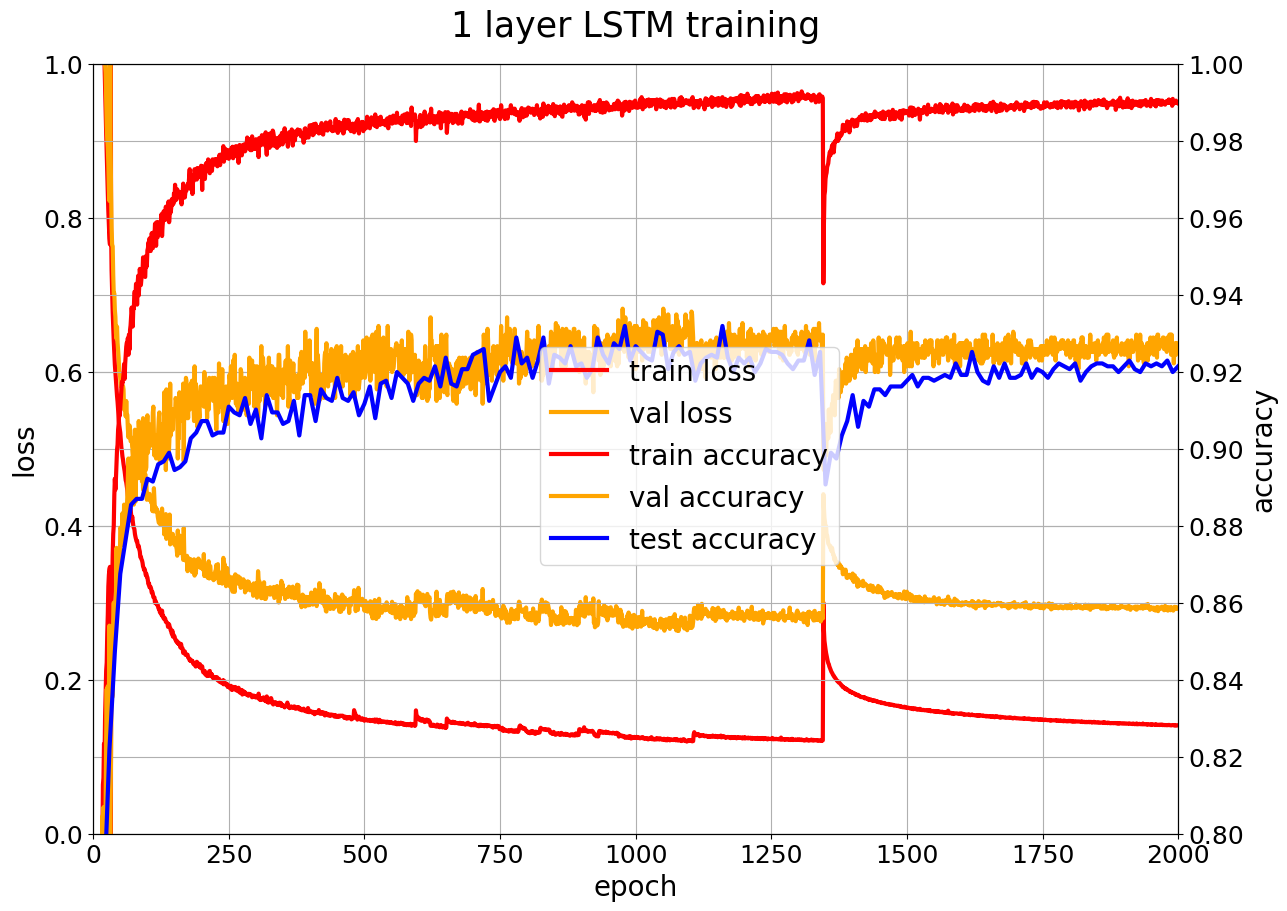

In [10]:
# AdamW, l2 weight_decay = 0.1, lr = 0.001, lr schedule exp decay gamma = 0.999, batch_size = 128, without feature standardization, 1 Layer LSTMt
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

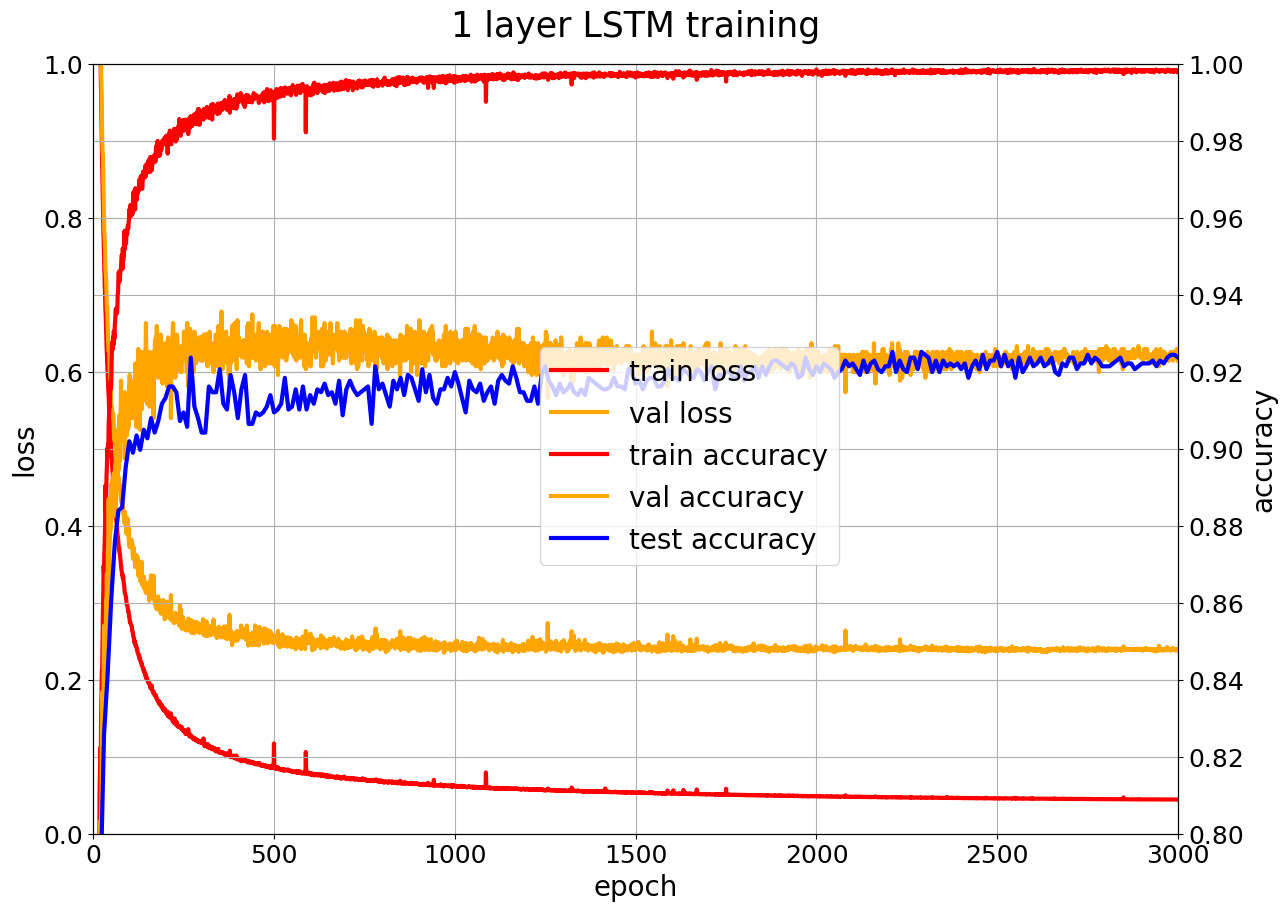

In [16]:
# AdamW, l2 weight_decay = 0.05, lr = 0.001, lr schedule exp decay gamma = 0.999, batch_size = 128, without feature standardization, 1 Layer LSTMt
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

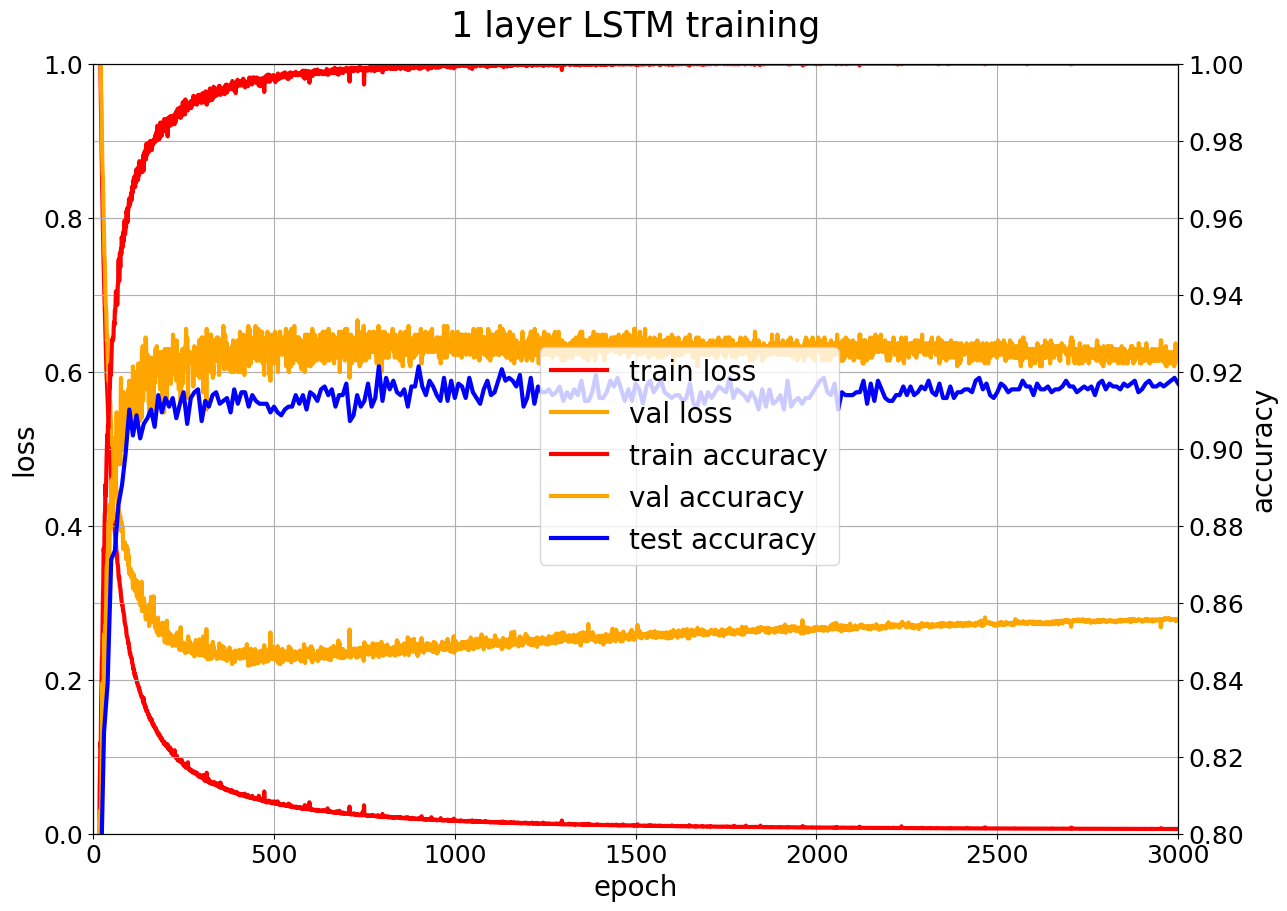

In [18]:
# AdamW, l2 weight_decay = 0.01, lr = 0.001, lr schedule exp decay gamma = 0.999, batch_size = 128, without feature standardization, 1 Layer LSTMt
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

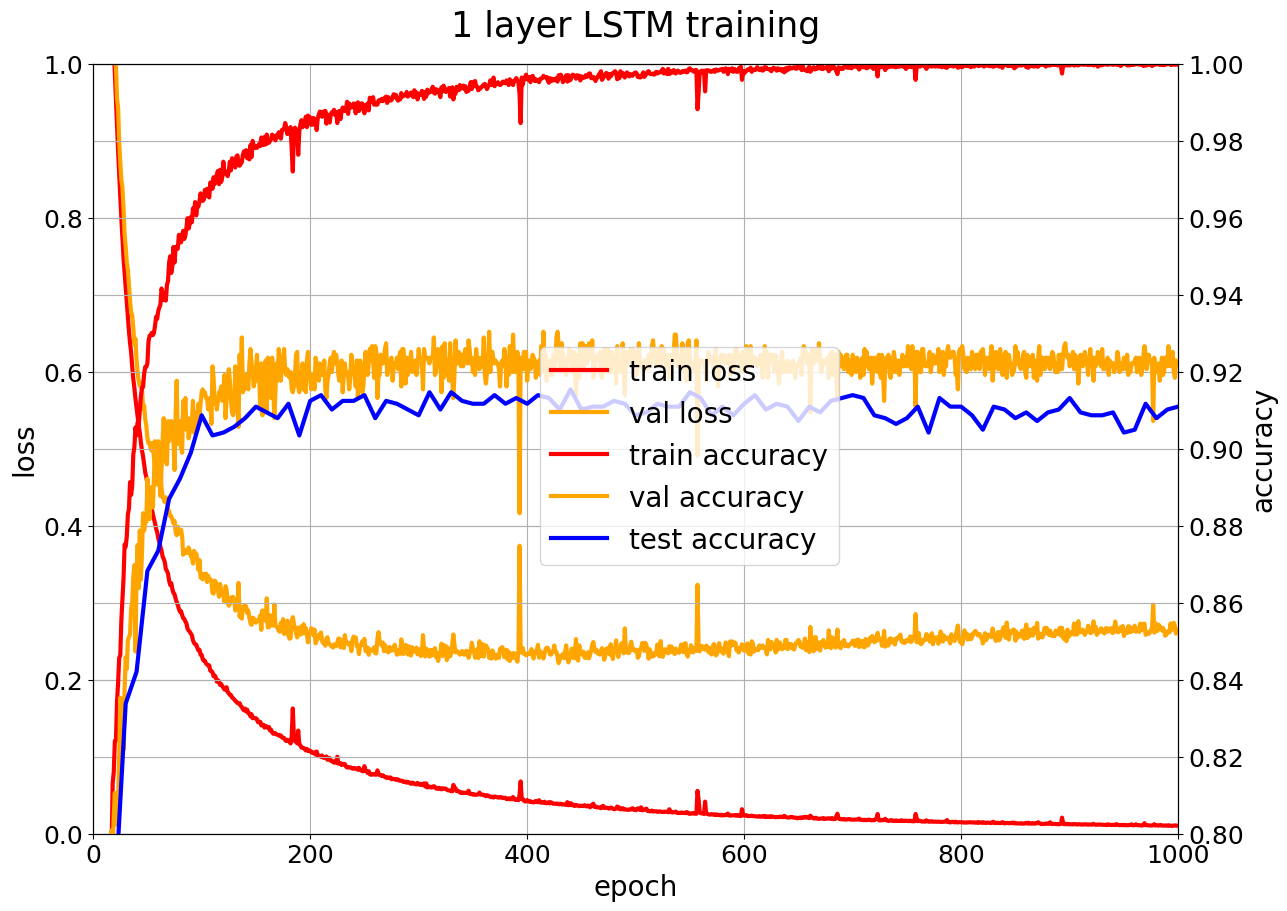

In [ ]:
# Adam, l2 weight_decay = 0, lr = 0.001, lr schedule exp decay gamma = 0.999, batch_size = 128, without feature standardization, 1 Layer LSTMt
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


Text(0.5, 1.025, '1 layer LSTM training')

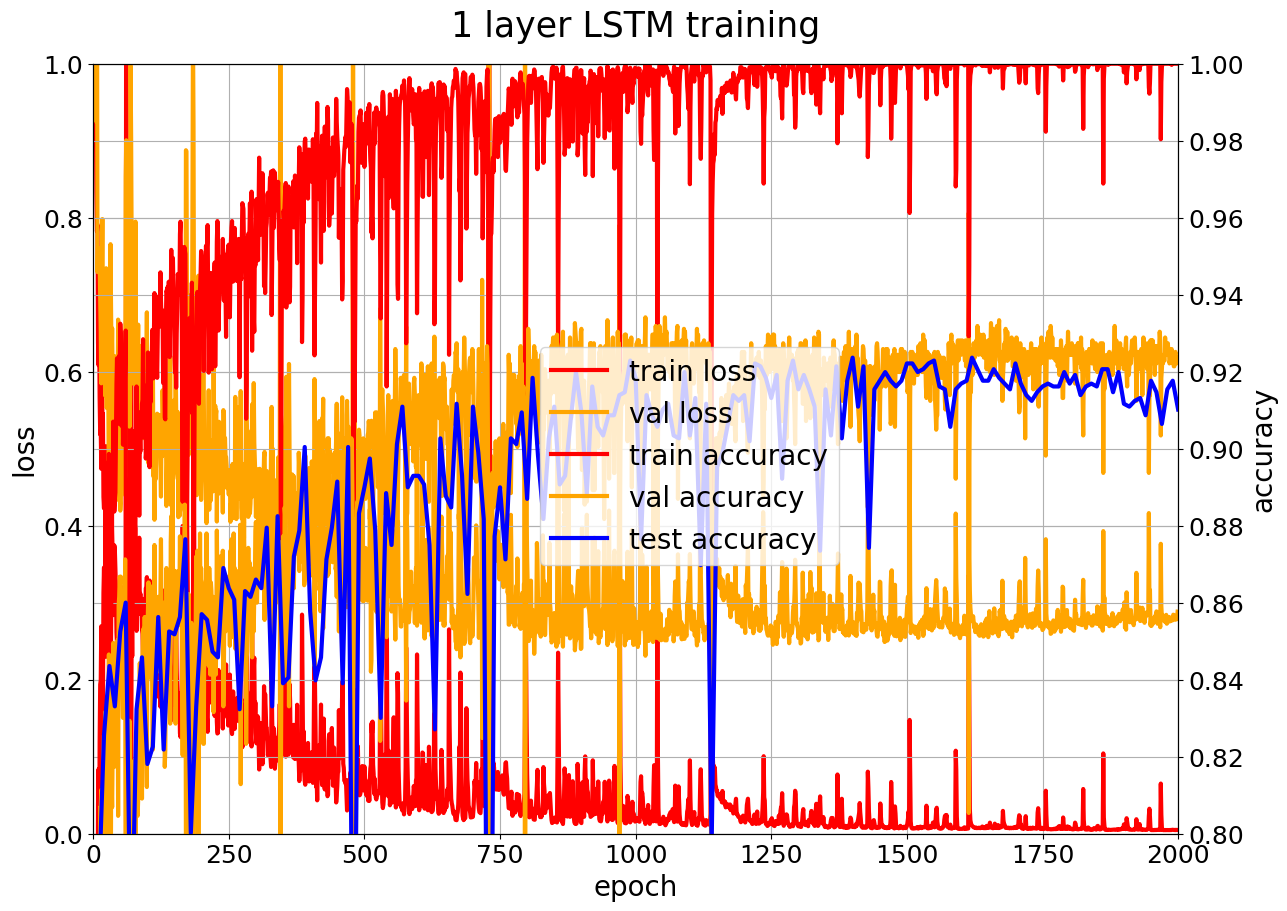

In [ ]:
# AdamW, l2 weight_decay = 0.01, lr = 0.01, lr schedule exp decay gamma = 0.999, batch_size = 128, without feature standardization, 1 Layer LSTMt
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


## No StandardScaler on time dimension

How about this time we apply StandardScaler() on features but the time dimension features in trajectory, and see how it goes.

In [11]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device=='cuda':
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False

# Batch_size
batch_size = 128

# Prepare data

# train and val data
i = 0
embryos_val = embryos_for_cross_validation[4*i:4*i+4]
embryos_train = [embryo_name for embryo_name in embryos_for_cross_validation if embryo_name not in embryos_val]
X_train, _, y_train = _utilities.prepare_data_for_model(embryo_cells_info, embryos_train, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)
X_val, _, y_val = _utilities.prepare_data_for_model(embryo_cells_info, embryos_val, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)
# test data
X_test, _, y_test = _utilities.prepare_data_for_model(embryo_cells_info, embryos_for_test, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)

# copy original X_train, X_val, and X_test data
X_train_original = np.array(X_train).copy()
X_val_original = np.array(X_val).copy()
X_test_original = np.array(X_test).copy()

# feature normalization
scaler = StandardScaler()
scaler.fit(np.array(X_train))
X_train = scaler.transform(np.array(X_train))
# standardize X_val and X_test
X_val = scaler.transform(np.array(X_val))
X_test = scaler.transform(np.array(X_test))
# restore time features to original
X_train[:, 0:200:4] = X_train_original[:,0:200:4]
X_val[:, 0:200:4] = X_val_original[:,0:200:4]
X_test[:, 0:200:4] = X_test_original[:,0:200:4]



# Dataset
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_train, dtype=np.float32)), torch.from_numpy(np.array(y_train)).type(torch.LongTensor))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_val, dtype=np.float32)), torch.from_numpy(np.array(y_val)).type(torch.LongTensor))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_test, dtype =np.float32)), torch.from_numpy(np.array(y_test)).type(torch.LongTensor))
# Dataloader 
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Train and Validate model
model = LSTMt(output_size=len(cells_of_interest)).to(device)
lr = 0.001
weight_decay=0.1 # L2 regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

num_epochs = 2000
test_interval = 10
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
test_accuracy = []

start_time = time.time()
# Training
for epoch in range(num_epochs):
    acc_train, loss_train = _utilities.train_mlp(model, train_dl, optimizer, device)
    acc_valid, loss_valid = _utilities.evaluate_mlp(model, val_dl, optimizer, device)
    scheduler.step() # adjust lr
    train_loss.append(loss_train)
    train_accuracy.append(acc_train)
    val_loss.append(loss_valid)
    val_accuracy.append(acc_valid)
    print(f'Epoch: {epoch+1:04d}/{num_epochs:04d} | '
          f'Accuracy: {acc_train:.4f} | '
          f'Val_accuracy: {acc_valid:.4f} | '
          f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
    if (epoch+1)%test_interval == 0: # test every 50 epochs
        # Test
        acc_test, _ = _utilities.evaluate_mlp(model, test_dl, optimizer, device)
        test_accuracy.append(acc_test)
        print(f'Test_accuracy: {acc_test:.4f}') 
# Test
acc_test, _ = _utilities.evaluate_mlp(model, test_dl, optimizer, device)
# test_accuracy.append(acc_test)
print(f'Final Test_accuracy: {acc_test:.4f}')

c:\Users\pmcesky\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 0001/2000 | Accuracy: 0.0156 | Val_accuracy: 0.0487 | Time elapsed: 0.01 min
Epoch: 0002/2000 | Accuracy: 0.0584 | Val_accuracy: 0.0816 | Time elapsed: 0.02 min
Epoch: 0003/2000 | Accuracy: 0.0931 | Val_accuracy: 0.1272 | Time elapsed: 0.02 min
Epoch: 0004/2000 | Accuracy: 0.1467 | Val_accuracy: 0.2028 | Time elapsed: 0.03 min
Epoch: 0005/2000 | Accuracy: 0.1994 | Val_accuracy: 0.2754 | Time elapsed: 0.03 min
Epoch: 0006/2000 | Accuracy: 0.2501 | Val_accuracy: 0.3301 | Time elapsed: 0.04 min
Epoch: 0007/2000 | Accuracy: 0.2945 | Val_accuracy: 0.3398 | Time elapsed: 0.04 min
Epoch: 0008/2000 | Accuracy: 0.3430 | Val_accuracy: 0.4034 | Time elapsed: 0.05 min
Epoch: 0009/2000 | Accuracy: 0.3961 | Val_accuracy: 0.4686 | Time elapsed: 0.06 min
Epoch: 0010/2000 | Accuracy: 0.4383 | Val_accuracy: 0.4888 | Time elapsed: 0.06 min
Test_accuracy: 0.4558
Epoch: 0011/2000 | Accuracy: 0.4801 | Val_accuracy: 0.5367 | Time elapsed: 0.07 min
Epoch: 0012/2000 | Accuracy: 0.5148 | Val_accuracy: 0.

Text(0.5, 1.025, '1 layer LSTM training')

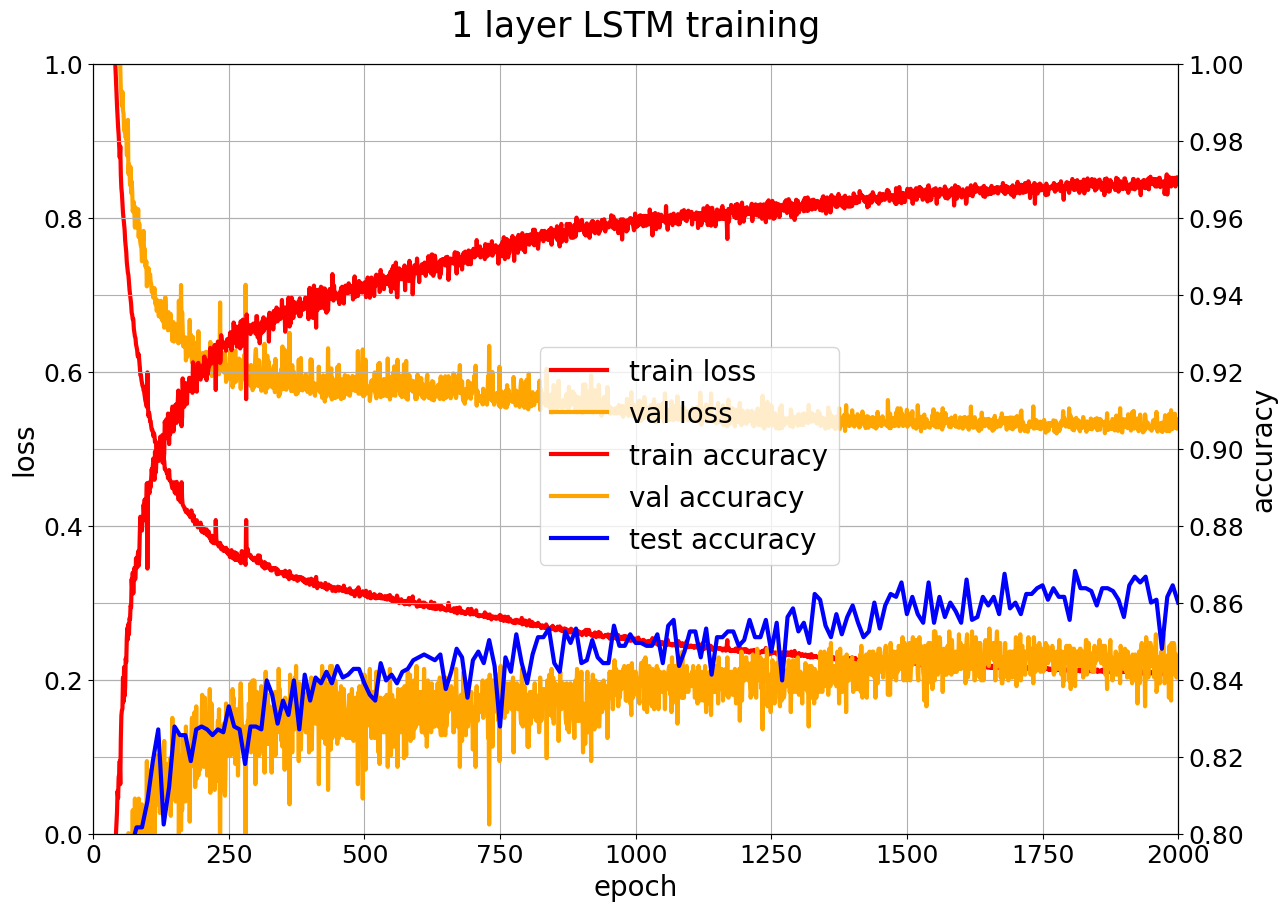

In [12]:
# AdamW, l2 weight_decay = 0.1, lr = 0.001, lr schedule exp decay gamma = 0.999, batch_size = 128, with feature standardization but time dimension, 1 Layer LSTMt
fig, ax1 = plt.subplots(figsize = (14, 10))
ax2 = ax1.twinx()
ax1.plot(np.arange(len(train_loss)), train_loss, 'r', linewidth = 3, label = 'train loss')
ax1.plot(np.arange(len(val_loss)), val_loss, 'orange', linewidth =3, label = 'val loss')
ax2.plot(np.arange(len(train_accuracy)), train_accuracy, 'r', linewidth = 3, label = 'train accuracy')
ax2.plot(np.arange(len(val_accuracy)), val_accuracy, 'orange', linewidth = 3, label = 'val accuracy')
ax2.plot(np.arange(1,len(test_accuracy)+1)*test_interval, test_accuracy, 'blue', linewidth = 3, label = 'test accuracy')
ax1.set_xlim(0, len(train_loss))
ax1.set_ylim(0,1)
ax2.set_ylim(0.80,1)
ax1.grid()
ax2.grid()
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax2.set_yticks([0.8,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98,1])
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('loss', fontsize = 20)
ax2.set_ylabel('accuracy', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(0.7,0.65), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('1 layer LSTM training', fontsize = 25, y = 1.025)


# Cross-Validation and Test Results analysis

In [9]:
print(embryos_for_cross_validation)

['WT-EMB01', 'WT-EMB02', 'WT-EMB03', 'WT-EMB04', 'WT-EMB06', 'WT-EMB07', 'WT-EMB08', 'WT-EMB09', 'WT-EMB10', 'WT-EMB11', 'WT-EMB13', 'WT-EMB14', 'WT-EMB15', 'WT-EMB16', 'WT-EMB17', 'WT-EMB18', 'WT-EMB20', 'WT-EMB21', 'WT-EMB22', 'WT-EMB23', 'WT-EMB24', 'WT-EMB25', 'WT-EMB27', 'WT-EMB28']


In [10]:
embryos_for_test

['WT-EMB05', 'WT-EMB12', 'WT-EMB19', 'WT-EMB26']

## 6-Fold Cross-Validation Results

In [11]:
with open( './lstmt/lstmt_full_cv_val_accuracy.json', 'r') as f:
   lstmt_full_cv_val_accuracy = json.load(f)
with open( './lstmt/lstmt_traj_cv_val_accuracy.json', 'r') as f:
   lstmt_traj_cv_val_accuracy = json.load(f)
with open( './lstmt/lstmt_traj_sf_cv_val_accuracy.json', 'r') as f:
   lstmt_traj_sf_cv_val_accuracy = json.load(f)
with open( './lstmt/lstmt_traj_sf_lf_cv_val_accuracy.json', 'r') as f:
   lstmt_traj_sf_lf_cv_val_accuracy = json.load(f)
with open( './lstmt/lstmt_traj_sf_lf_dm_cv_val_accuracy.json', 'r') as f:
   lstmt_traj_sf_lf_dm_cv_val_accuracy = json.load(f)

## Test result on test embryo samples

In [12]:
with open( './lstmt/lstmt_full_test_test_accuracy.json', 'r') as f:
   lstmt_full_test_test_accuracy = json.load(f)
with open( './lstmt/lstmt_traj_test_test_accuracy.json', 'r') as f:
   lstmt_traj_test_test_accuracy = json.load(f)
with open( './lstmt/lstmt_traj_sf_test_test_accuracy.json', 'r') as f:
   lstmt_traj_sf_test_test_accuracy = json.load(f)
with open( './lstmt/lstmt_traj_sf_lf_test_test_accuracy.json', 'r') as f:
   lstmt_traj_sf_lf_test_test_accuracy = json.load(f)
with open( './lstmt/lstmt_traj_sf_lf_dm_test_test_accuracy.json', 'r') as f:
   lstmt_traj_sf_lf_dm_test_test_accuracy = json.load(f)

## lstm full features

In [13]:
# cross-validation final validation accuracy
np.array(lstmt_full_cv_val_accuracy)[:,-1]

array([0.92290419, 0.90868263, 0.91991018, 0.90419162, 0.91541916,
       0.81886228])

In [14]:
# cross-validation final validation accuracy mean
np.array(lstmt_full_cv_val_accuracy)[:,-1].mean()

0.8983283433133734

In [15]:
# cross-validation final validation accuracy max
np.max(np.array(lstmt_full_cv_val_accuracy), axis=1)

array([0.92964072, 0.91242515, 0.92290419, 0.91167665, 0.9258982 ,
       0.83982036])

In [16]:
# test result --- final test accuracy
np.array(lstmt_full_test_test_accuracy)[-1]

0.9318862275449101

In [17]:
# test result --- max test accuracy
np.array(lstmt_full_test_test_accuracy).max()

0.9356287425149701

## lstm trajectory only feature

In [18]:
# cross-validation final validation accuracy
np.array(lstmt_traj_cv_val_accuracy)[:,-1]

array([0.84580838, 0.81362275, 0.85329341, 0.83757485, 0.81661677,
       0.73727545])

In [19]:
# cross-validation final validation accuracy mean
np.array(lstmt_traj_cv_val_accuracy)[:,-1].mean()

0.8173652694610779

In [20]:
# cross-validation final validation accuracy max
np.max(np.array(lstmt_traj_cv_val_accuracy), axis=1)

array([0.85928144, 0.83233533, 0.86377246, 0.84805389, 0.8255988 ,
       0.74401198])

In [21]:
# test result --- final test accuracy
np.array(lstmt_traj_test_test_accuracy)[-1]

0.8585329341317365

In [22]:
# test result --- max test accuracy
np.array(lstmt_traj_test_test_accuracy).max()

0.8592814371257484

## lstm trajectory + start_frame feature

In [23]:
# cross-validation final validation accuracy
np.array(lstmt_traj_sf_cv_val_accuracy)[:,-1]

array([0.88547904, 0.85254491, 0.86077844, 0.85628743, 0.8502994 ,
       0.75598802])

In [24]:
# cross-validation final validation accuracy mean
np.array(lstmt_traj_sf_cv_val_accuracy)[:,-1].mean()

0.843562874251497

In [25]:
# cross-validation final validation accuracy max
np.max(np.array(lstmt_traj_sf_cv_val_accuracy), axis=1)

array([0.89071856, 0.86077844, 0.8742515 , 0.86526946, 0.86227545,
       0.76646707])

In [26]:
# test result --- final test accuracy
np.array(lstmt_traj_sf_test_test_accuracy)[-1]

0.8839820359281437

In [27]:
# test result --- max test accuracy
np.array(lstmt_traj_sf_test_test_accuracy).max()

0.8854790419161677

## lstm trajectory + start_frame + lifespan_frame feature

In [28]:
# cross-validation final validation accuracy
np.array(lstmt_traj_sf_lf_cv_val_accuracy)[:,-1]

array([0.8757485 , 0.85179641, 0.85329341, 0.85628743, 0.85479042,
       0.7761976 ])

In [29]:
# cross-validation final validation accuracy mean
np.array(lstmt_traj_sf_lf_cv_val_accuracy)[:,-1].mean()

0.844685628742515

In [30]:
# cross-validation final validation accuracy max
np.max(np.array(lstmt_traj_sf_lf_cv_val_accuracy), axis=1)

array([0.88547904, 0.85703593, 0.86751497, 0.86526946, 0.86452096,
       0.78368263])

In [31]:
# test result --- final test accuracy
np.array(lstmt_traj_sf_lf_test_test_accuracy)[-1]

0.8824850299401198

In [32]:
# test result --- max test accuracy
np.array(lstmt_traj_sf_lf_test_test_accuracy).max()

0.8854790419161677

## lstm trajectory + start_frame + lifespan_frame + division_orientation_to_mother_cell feature

In [33]:
# cross-validation final validation accuracy
np.array(lstmt_traj_sf_lf_dm_cv_val_accuracy)[:,-1]

array([0.93413174, 0.89820359, 0.92215569, 0.90718563, 0.91916168,
       0.82260479])

In [34]:
# cross-validation final validation accuracy mean
np.array(lstmt_traj_sf_lf_dm_cv_val_accuracy)[:,-1].mean()

0.9005738522954091

In [35]:
# cross-validation final validation accuracy max
np.max(np.array(lstmt_traj_sf_lf_dm_cv_val_accuracy), axis=1)

array([0.93562874, 0.9011976 , 0.93263473, 0.91541916, 0.92739521,
       0.83308383])

In [36]:
# test result --- final test accuracy
np.array(lstmt_traj_sf_lf_dm_test_test_accuracy)[-1]

0.9244011976047904